# Getting the data from Kaggle

In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle competitions download -c dog-breed-identification  #(Dataset link)
!unzip dog-breed-identification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# dataset
import os
import math
import glob
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, Subset, DataLoader
import matplotlib.pyplot as plt

# save result
import pickle

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
img_names = glob.glob("train/*.jpg")

print(f'Total images in Dataset : {len(img_names)}')

Total images in Dataset : 10222


In [8]:
class DogDataset(Dataset):

    def __init__(self, img_path, csv_path):
        self.csv_path = csv_path
        self.transform = None

        self.img_names = glob.glob(f"{img_path}/*.jpg")

        if csv_path:
            label_df = pd.read_csv(csv_path)
            self.label_idx2name = label_df['breed'].unique()
            self.label_name2idx = {}
            for i in range(len(self.label_idx2name)):
                self.label_name2idx[self.label_idx2name[i]] = i
            self.img2label = {}
            for _, row in label_df.iterrows():
                self.img2label[f"{img_path}/{row['id']}.jpg"] = self.label_name2idx[row['breed']]
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, index):
        img = self.img_names[index]

        if self.csv_path:
            label = self.img2label[img]
            label = torch.tensor(label)
        else:
            label = -1
        
        img = Image.open(img).convert("RGB")
        img = self.transform(img)
        return (img, label)

In [9]:
# transform_fn for pretrained ViT
channel_mean = torch.Tensor([0.485, 0.456, 0.406])
channel_std = torch.Tensor([0.229, 0.224, 0.225])

vit_train_transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),

    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomRotation(degrees=(30)),

    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

vit_valid_transform_fn = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=channel_mean, std=channel_std),
])

In [10]:
dataset = DogDataset(
    img_path="train",
    csv_path="labels.csv",
)


In [11]:
indexes = list(range(len(dataset)))
train_indexes, valid_indexes = train_test_split(indexes, test_size=0.1)
train_dataset = Subset(dataset, train_indexes)
valid_dataset = Subset(dataset, valid_indexes)

print(f"Number of samples in train_dataset: {len(train_dataset)}")
print(f"Number of samples in valid_dataset: {len(valid_dataset)}")

Number of samples in train_dataset: 9199
Number of samples in valid_dataset: 1023


In [12]:
dataset.transform = vit_train_transform_fn
train_dataset.transform = vit_train_transform_fn
valid_dataset.transform = vit_valid_transform_fn

In [13]:
train_valid_dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=32,
    shuffle=True
)


In [14]:
def show_samples(batch_img, batch_label=None, num_samples=16):

    sample_idx = 0
    total_col = 4
    total_row = math.ceil(num_samples / 4)
    col_idx = 0
    row_idx = 0

    fig, axs = plt.subplots(total_row, total_col, figsize=(15, 15))

    while sample_idx < num_samples:
        img = batch_img[sample_idx]
        img = img.view(3, -1) * channel_std.view(3, -1) + channel_mean.view(3, -1)
        img = img.view(3, 224, 224)
        img = img.permute(1, 2, 0)
        axs[row_idx, col_idx].imshow(img)

        if batch_label != None:
            axs[row_idx, col_idx].set_title(dataset.label_idx2name[(batch_label[sample_idx])])

        sample_idx += 1
        col_idx += 1
        if col_idx == 4:
            col_idx = 0
            row_idx += 1

In [16]:
batch_img, batch_label = next(iter(train_dataloader))

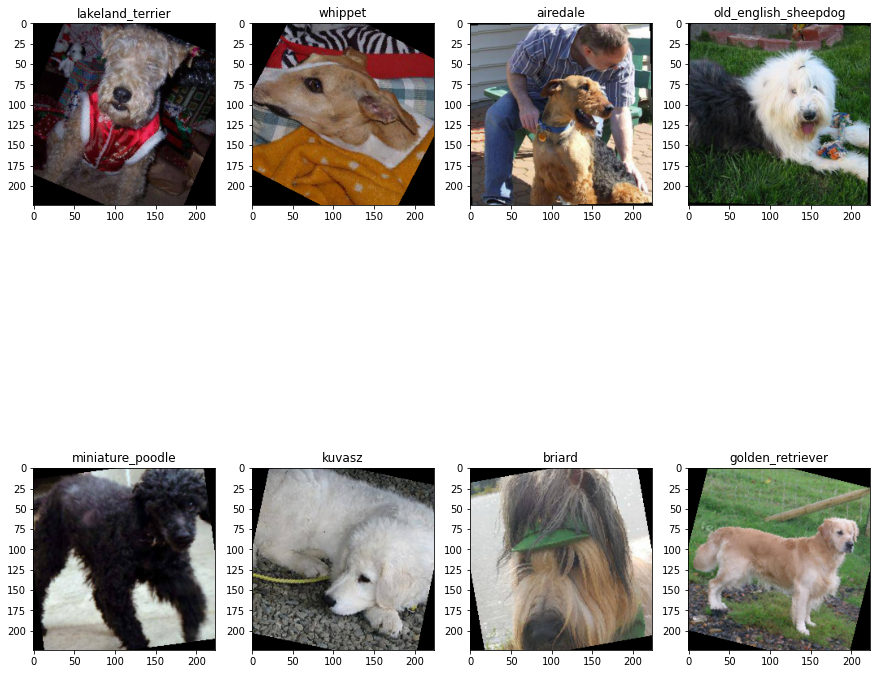

In [17]:
show_samples(batch_img, batch_label, 8)

In [20]:
class PretrainViT(nn.Module):

    def __init__(self):
        super(PretrainViT, self).__init__()
        model = models.vit_l_16(pretrained=True)
        num_classifier_feature = model.heads.head.in_features
        model.heads.head = nn.Sequential(
            nn.Linear(num_classifier_feature, 120)
        )
        self.model = model

        for param in self.model.named_parameters():
            if "heads" not in param[0]:
                param[1].requires_grad = False

    def forward(self, x):
        return self.model(x)


In [21]:
net = PretrainViT()
net.to(device)
print(f"number of paramaters: {sum([param.numel() for param in net.parameters() if param.requires_grad])}")

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

number of paramaters: 123000


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)

In [23]:
def get_accuracy(output, label):
    output = output.to("cpu")
    label = label.to("cpu")

    sm = F.softmax(output, dim=1)
    _, index = torch.max(sm, dim=1)
    return torch.sum((label == index)) / label.size()[0]


In [24]:
def train(model, dataloader):
    model.train()
    running_loss = 0.0
    total_loss = 0.0
    running_acc = 0.0
    total_acc = 0.0

    for batch_idx, (batch_img, batch_label) in enumerate(dataloader):

        batch_img = batch_img.to(device)
        batch_label = batch_label.to(device)

        optimizer.zero_grad()
        output = net(batch_img)
        loss = criterion(output, batch_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_loss += loss.item()

        acc = get_accuracy(output, batch_label)
        running_acc += acc
        total_acc += acc

        if batch_idx % 100 == 0 and batch_idx != 0:
            print(f"[step: {batch_idx:4d}/{len(dataloader)}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0
            running_acc = 0.0
    
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [26]:
EPOCHS = 7
train_loss_history = []
valid_loss_history = []

train_acc_history = []
valid_acc_history = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(net, train_dataloader)
    valid_loss, valid_acc = validate(net, valid_dataloader)
    print(f"Epoch: {epoch:2d}, training loss: {train_loss:.3f}, training acc: {train_acc:.3f} validation loss: {valid_loss:.3f}, validation acc: {valid_acc:.3f}")

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    train_acc_history.append(train_acc)
    valid_acc_history.append(valid_acc)

    if valid_loss <= min(valid_loss_history):
        torch.save(net.state_dict(), "net.pt")



[step:  100/1150] loss: 2.522
[step:  200/1150] loss: 0.480
[step:  300/1150] loss: 0.248
[step:  400/1150] loss: 0.199
[step:  500/1150] loss: 0.147
[step:  600/1150] loss: 0.171
[step:  700/1150] loss: 0.145
[step:  800/1150] loss: 0.154
[step:  900/1150] loss: 0.116
[step: 1000/1150] loss: 0.111
[step: 1100/1150] loss: 0.170
Epoch:  0, training loss: 0.394, training acc: 0.927 validation loss: 0.118, validation acc: 0.968
[step:  100/1150] loss: 0.065
[step:  200/1150] loss: 0.097
[step:  300/1150] loss: 0.087
[step:  400/1150] loss: 0.089
[step:  500/1150] loss: 0.094
[step:  600/1150] loss: 0.104
[step:  700/1150] loss: 0.067
[step:  800/1150] loss: 0.098
[step:  900/1150] loss: 0.075
[step: 1000/1150] loss: 0.081
[step: 1100/1150] loss: 0.076
Epoch:  1, training loss: 0.085, training acc: 0.977 validation loss: 0.131, validation acc: 0.966
[step:  100/1150] loss: 0.069
[step:  200/1150] loss: 0.070
[step:  300/1150] loss: 0.052
[step:  400/1150] loss: 0.050
[step:  500/1150] loss